<a href="https://colab.research.google.com/github/MichaelDeng03/GenAI_Agents/blob/michael%2Ffinal_notebook/final_notebook/all_agents_tutorials/art_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/MichaelDeng03/GenAI_Agents/blob/main/all_agents_tutorials/art_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Art Agent
This tutorial will walk through the creation of an AI Agent that helps you explore and learn art!

### Overview
For knowledge retrieval, this tutorial uses [LightRAG](https://github.com/HKUDS/LightRAG) which is knowledge graph based RAG implementation. Compared to GraphRAG, LightRAG is more accurate for single topic datasets, and uses 1,000x less tokens for retrieval. Furthermore, documents can be added to LightRAG incrementally without rebuilding the knowledge graph. See the full results in the [paper](https://arxiv.org/abs/2410.05779).

For the agent itself, we use LangGraph.

### Outline
0. [Setup](#setup)
1. [Data Preparation + RAG](#data-preparation--rag)
2. [Agent Creation](#agent-creation)
3. [Final App](#final-app)

### Setup

#### Environment

This tutorial uses openai embedding models. While there are alternatives, we recommend using the openai models for the best results.

```
export OPENAI_API_KEY=sk....
```

In [1]:
!export OPENAI_API_KEY=  # sk-proj...

In [12]:
!uv venv

Using CPython 3.10.12 interpreter at: /usr/bin/python3
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate


In [13]:
!uv pip install lightrag-hku aioboto3 numpy ollama openai tenacity aioboto3 transformers torch tiktoken nano_vectordb neo4j oracledb textract setuptools pyvis sqlalchemy langchain_community langchain_openai sqlmodel ipywidgets==7.7.1 asyncio markdown langgraph -q

In [15]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, TwoByTwoLayout, Text, AppLayout, GridspecLayout
import ipywidgets as widgets
from IPython.display import Markdown

import json
import os
import operator
import random
from datetime import datetime
from typing import Any, Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod

from IPython.display import display, Image as IPImage

# from lightrag.llm import gpt_4o_mini_complete
# from lightrag import LightRAG, QueryParam
from dotenv import load_dotenv

from pprint import pprint

from langchain.globals import set_debug

from io import BytesIO
from PIL import Image as PILImage

### Data Preparation + RAG

#### Data Preparation

We scraped data from [wikiart](https://wikiart.org/) using a combination of requests and beautiful soup.

We provide a preprocessed, limited dataset of this data for the tutorial found in `data/artinfo.json`.

Preprocessed data for each artwork looks like:

```plaintext
Artwork Name: {artwork_name}
Artwork Genre: {genre_list}
Artwork Media: {media_list}
Wikiart URL: https://www.wikiart.org{wikiart_slug}

Wikipedia Article:
{wiki_article}
```


#### LightRAG


In [16]:
artwork_info = None
with open('./data/artinfo.json', 'r') as f:
    artwork_info = json.load(f)['info']
print(len(artwork_info))
print(artwork_info[0])

1541

Artist: Frederick McCubbin
Artwork Name: Down on his luck
Artwork Genre: genre painting
Artwork Media: canvas,oil
Wikiart URL: https://www.wikiart.org/en/frederick-mccubbin/down-on-his-luck-1889

Wikipedia Article:
 The painting was owned by William Fergusson up to 1986 until it was purchased by the Art Gallery of Western Australia in Perth.



In [ ]:
from lightrag.llm import gpt_4o_mini_complete
from lightrag import LightRAG, QueryParam

import nest_asyncio

nest_asyncio.apply()
WORKING_DIR = "./data"
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=gpt_4o_mini_complete,
)

INFO:lightrag:Logger initialized for working directory: ./data
INFO:lightrag:Load KV llm_response_cache with 337 data
INFO:lightrag:Load KV full_docs with 78 data
INFO:lightrag:Load KV text_chunks with 78 data
INFO:lightrag:Loaded graph from ./data/graph_chunk_entity_relation.graphml with 711 nodes, 642 edges
INFO:nano-vectordb:Load (709, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_entities.json'} 709 data
INFO:nano-vectordb:Load (642, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_relationships.json'} 642 data
INFO:nano-vectordb:Load (78, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_chunks.json'} 78 data


In [ ]:
import time

# Create the RAG database
batch_size = 30

# Loop through the list in batches of 30 to avoid rate limits
for i in range(0, len(artwork_info), 30):
    batch = artwork_info[i : i + batch_size]
    rag.insert(batch)
    time.sleep(15)

NameError: name 'artwork_info' is not defined

### Agent Creation

In [ ]:
def get_artwork_image_url(url: str):
    """
    Gets an artwork image from its URL.
    """
    import requests
    from bs4 import BeautifulSoup as bs

    response = requests.get(url)
    soup = bs(response.text, "html.parser")
    img = soup.find("img", {"itemprop": "image"})

    return img.get("src")

In [ ]:
from ipywidgets import GridspecLayout, widgets
from ipywidgets import VBox
import markdown

import requests
from PIL import Image as PILImage
from ipywidgets import GridspecLayout, widgets
import markdown


def image_widget_value(artwork_url: str):
    image_url = get_artwork_image_url(artwork_url)
    resp = requests.get(image_url)
    if resp.status_code == 200:
        image = PILImage.open(BytesIO(resp.content))
        width, height = image.size
    else:
        return 'No image found'

    return f'<img src={image_url} style="width:{width}px;height:{height}px;">'


def html_widget_value(description: str):
    style = (
        "display: inline-block; "
        "width: fit-content; "
        "max-width: 100%; "  # Optional to prevent excessive width
        "padding: 5px; "
        "font-size: 16px; "
        "line-height: 1.5; "
        "border: 1px solid #ccc; "  # Optional, for visibility
        "border-radius: 5px; "
        "background-color: #f9f9f9;"
    )
    return f'<div style="{style}">{markdown.markdown(description)}</div>'

In [ ]:
class ArtTourState(TypedDict):
    artwork: str
    artwork_metadata: str
    artwork_description: str
    artwork_url: str
    art_request: str
    past_artworks: list[str]
    discussion_messages: list[str]
    app_message: str  # intro and conclusion
    exit: bool

    footer: widgets.HTML
    header: widgets.HTML
    image: widgets.HTML

In [ ]:
def get_artwork_url_from_name(state: ArtTourState):
    artwork_name = state['artwork']
    prompt = f"""
    What is the Wikiart URL for this artwork: {artwork_name}

    Return only the wikiart url in plain text.
    """
    return {"artwork_url": rag.query(prompt, param=QueryParam(mode="hybrid"))}

In [ ]:
def describe_artwork(state: ArtTourState):
    artwork = state['artwork']
    metadata = rag.query(
        f"""What is the genre, media, and style of the following artwork: {artwork}.
    Return the description in the following format:
    artwork name: <artwork name>
    artist: <artist>
    genre: <genre>
    media: <media>
    style: <style>

    Return this information and nothing else.
    """,
        param=QueryParam(mode="hybrid"),
    )

    dense_description = str(
        rag.query(
            f"Describe the imagery and context of {artwork} in 2 concise paragraphs.", param=QueryParam(mode="hybrid")
        )
    )

    return {
        "artwork_metadata": metadata,
        "artwork_description": dense_description,
        **get_artwork_url_from_name(state),
    }

In [ ]:
def request_artwork(state: ArtTourState):
    description = state['art_request']
    prompt = f"""
    The user has requested the following for their next artwork. Choose a related artwork.
    {description}

    Return the name of the artwork and nothing else.
    """
    return {"artwork": rag.query(prompt, param=QueryParam(mode="hybrid"))}


def get_next_artwork(state: ArtTourState):

    prev_artwork = state['artwork_metadata']
    next_artwork = state['art_request']
    past_artworks = state['past_artworks']
    prompt = f"""You are an art tour guide.
    The have discussed these artworks earlier in the tour: {past_artworks}
    You just discussed this artwork:
    {prev_artwork}

    The user has requested the following for their next artwork. Choose a related artwork.
    {next_artwork}

    Return the name of the artwork and nothing else.
    """
    next_artwork = rag.query(prompt, param=QueryParam(mode="hybrid"))
    art_data = describe_artwork({'artwork': next_artwork})
    out = {
        "artwork": next_artwork,
        "past_artworks": past_artworks + [prev_artwork],
        **art_data,  # metadata + description
    }
    out.update(art_data)
    return out

In [ ]:
with open('./data/artinfo.json', 'r') as f:
    art_json = json.load(f)
artworks = [art_info.split('\n')[2].split(': ')[1] for art_info in art_json['info']]


def get_random_art():
    out = {"artwork": random.sample(artworks, 1)[0]}
    art_data = describe_artwork(out)
    out.update(art_data)
    return out

In [ ]:
tour_instructions = """
You will be shown an artwork and a description.
Take a close look and articulate what you see, think, and feel.
Afterwards, you may describe an area of interest to continue exploring or view a new random artwork.
At the end, you'll be give a list of all the artworks you've seen.
"""

def tour_introduction(state: ArtTourState):
    out = get_random_art()
    out['app_message'] = tour_instructions
    return out

def conclude_tour(state: ArtTourState):
    summary = str(
        rag.query(
            f"""
            Build a narrative and summarize the themes of an art tour you just gave with these artworks
            {[state['artwork_metadata']] + state['past_artworks']}
            Start by writing a short introduction.
            Write no more than 2 sentences about any particular artwork.
            End by writing a short conclusion.
            Thank the user for their engagement.
            """,
            param=QueryParam(mode="hybrid")
        )
    )

    tour_conclusion = f"""
    Thank you for doing a tour!
    These are the artworks you viewed:
    {"\n".join(state['past_artworks'])}

    Here's a summary of the themes:
    {summary}
    """
    return {'app_message': tour_conclusion}

def display_artwork(state: ArtTourState):
    """
    Render the widgets
    """

    state['footer'].value = html_widget_value(state['artwork_description'])

    state['header'].value = html_widget_value(state['artwork'])

    state['image'].value = image_widget_value(state['artwork_url'])


    return state


def choose_next_artwork(state: ArtTourState):
    # Capture user message
    user_input = "I would like something more colorful"
    state['art_request'] = user_input
    return get_next_artwork(state)

def discuss(state: ArtTourState):
    """
    Discuss the artwork with the user
    """
    while True:
        # Capture user message
        user_input = input()

        if user_input == 'next':
            return state
        if user_input == 'exit':
            state['exit'] = True
            return state

        summary = str(
            rag.query(
                f"""
                The user has said:
                {user_input}
                about the artwork:
                {state['artwork']}

                Respond with 1-2 sentences enriching the user with new facts or feedback.
                """,
                param=QueryParam(mode="hybrid")
            )
        )


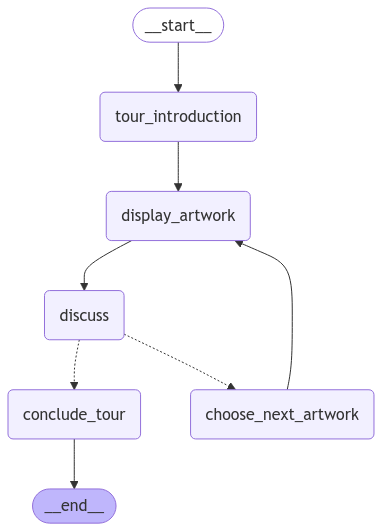

In [ ]:
from typing import Literal


workflow = StateGraph(ArtTourState)
# nodes
workflow.add_node('tour_introduction', tour_introduction)
workflow.add_node('display_artwork', display_artwork)
workflow.add_node('choose_next_artwork', choose_next_artwork)

workflow.add_node('discuss', discuss)
workflow.add_node('conclude_tour', conclude_tour)

workflow.add_edge('tour_introduction', 'display_artwork')
workflow.add_edge('display_artwork', 'discuss')

workflow.add_edge('choose_next_artwork', 'display_artwork')
workflow.add_edge('conclude_tour', END)


def conclude_or_moreart(state: ArtTourState) -> Literal['conclude_tour', 'choose_next_artwork']:
    if state.get('exit'):
        return 'conclude_tour'
    return 'choose_next_artwork'


workflow.add_conditional_edges('discuss', conclude_or_moreart)

workflow.set_entry_point('tour_introduction')
app = workflow.compile()
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Final App

In [ ]:
# Final User Loop
load_dotenv()
header = widgets.HTML(value=html_widget_value("Welcome to the Art Tour!"))
image = widgets.HTML(value="")
footer = widgets.HTML(value="")
display(widgets.VBox([header, image, footer]))
app.invoke({"artwork": None, "past_artworks": [], 'header': header, 'image': image, 'footer': footer})

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 141 relations, 12 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 39 entites, 60 relations, 11 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 7.342000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 2.216000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Requ

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 118 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 39 entites, 60 relations, 7 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 145 relations, 10 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 41 entites, 60 relations, 6 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 154 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 34 entites, 60 relations, 6 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'artwork': '**A Girl with a Watering Can**',
 'artwork_metadata': '```markdown\nartwork name: A Girl with a Watering Can  \nartist: Pierre-Auguste Renoir  \ngenre: genre painting  \nmedia: canvas, oil  \nstyle: Impressionism  \n```',
 'artwork_description': "**A Girl with a Watering Can**, painted by Pierre-Auguste Renoir in 1876, features a young girl named Mademoiselle Leclere depicted in a radiant blue dress, holding a watering can. The artwork captures a moment of domesticity and innocence within an impressionist framework, emphasizing the girl's joyful interaction with her environment. Renoir's use of bright colors and soft brushstrokes not only highlights the subject's playful demeanor but also showcases the gardens of Argenteuil, where the painting was created. The painting reflects the genre painting trend of the time, focusing on everyday life and infusing it with a sense of beauty and warmth.\n\nThe context surrounding **A Girl with a Watering Can** is significant as it repr

In [ ]:
print(html_widget_value("Welcome to the Art Tour!"))
header = widgets.HTML(value=html_widget_value("Welcome to the Art Tour!"))
image = widgets.HTML(value=html_widget_value("https://www.wikiart.org/en/claude-monet/water-lilies-1916"))
footer = widgets.HTML(value=html_widget_value("Water Lilies by Claude Monet"))
display(widgets.VBox([header, image, footer]))

<div style="display: inline-block; width: fit-content; max-width: 100%; padding: 5px; font-size: 16px; line-height: 1.5; border: 1px solid #ccc; border-radius: 5px; background-color: #f9f9f9;"><p>Welcome to the Art Tour!</p></div>


In [ ]:
widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

IntSlider(value=7, continuous_update=False, description='Test:', max=10)